## AP sprint to use analysis_tools to try to make a plot, Sep 2022

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
from typing import Mapping, cast

from matplotlib.figure import Figure
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd

In [109]:
import lsst.daf.butler as dafButler
from lsst.pex.config import Config, ConfigDictField, Field
#from lsst.pex.config.listfield import ListField

import lsst.analysis.tools  # my own recent build of main, not the weekly
from lsst.analysis.tools.interfaces import AnalysisPlot
from lsst.analysis.tools.actions.vector import RangeSelector, LoadVector, DownselectVector
from lsst.analysis.tools.interfaces import PlotAction, KeyedDataSchema, Vector, KeyedData

In [4]:
#repo = '/sdf/group/rubin/repo/main_20220411'
#repo = '/fs/ddn/sdf/group/rubin/sandbox/bechtol/rc2_subset/SMALL_HSC' # collections='u/bechtol/step3'
#repo = '/sdf/group/rubin/u/ebellm/workspace/cosmos/repo'
#repo = '/sdf/group/rubin/u/ebellm/workspace/hits/repo'
repo = '/sdf/group/rubin/repo/main'
collections = 'u/mrawls/DM-34710/hits2015-fakes'
butler = dafButler.Butler(repo, collections=collections)

In [5]:
registry = butler.registry

## This is the part where I explore what is in the collection

In [65]:
# for d in sorted(registry.queryDatasetTypes()): print(d.name)

In [62]:
# sorted(registry.queryDatasets('fakes_goodSeeingDiff_diaSrcTable'))

In [63]:
# sorted(registry.queryDatasets('fakes_goodSeeingDiff_assocDiaSrc'))

In [64]:
# sorted(registry.queryDatasets('visitSummary'))  # womp womp, only 2014 (template) visits here

In [10]:
oneDiaSrcTable = butler.get('fakes_goodSeeingDiff_diaSrcTable', band='g', instrument='DECam', visit=410929, detector=12)

In [11]:
oneDiaSrcTable.columns

Index(['diaSourceId', 'ccdVisitId', 'filterName', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'midPointTai', 'bboxSize', 'flags', 'ra', 'decl',
       'x', 'y', 'xErr', 'yErr', 'apFlux', 'apFluxErr', 'snr', 'psFlux',
       'psFluxErr', 'psChi2', 'psNdata', 'trailFlux', 'trailRa', 'trailDecl',
       'trailLength', 'trailAngle', 'dipMeanFlux', 'dipMeanFluxErr',
       'dipFluxDiff', 'dipFluxDiffErr', 'dipLength', 'dipAngle', 'dipChi2',
       'isDipole', 'totFlux', 'totFluxErr', 'ixx', 'iyy', 'ixy', 'ixxPSF',
       'iyyPSF', 'ixyPSF'],
      dtype='object')

In [12]:
oneAssocDiaSrc = butler.get('fakes_goodSeeingDiff_assocDiaSrc', band='g', instrument='DECam', visit=410929, detector=12)

In [13]:
oneAssocDiaSrc.columns

Index(['diaSourceId', 'ccdVisitId', 'filterName', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'midPointTai', 'bboxSize', 'flags', 'ra', 'decl',
       'x', 'y', 'xErr', 'yErr', 'apFlux', 'apFluxErr', 'snr', 'psFlux',
       'psFluxErr', 'psChi2', 'psNdata', 'trailFlux', 'trailRa', 'trailDecl',
       'trailLength', 'trailAngle', 'dipMeanFlux', 'dipMeanFluxErr',
       'dipFluxDiff', 'dipFluxDiffErr', 'dipLength', 'dipAngle', 'dipChi2',
       'isDipole', 'totFlux', 'totFluxErr', 'ixx', 'iyy', 'ixy', 'ixxPSF',
       'iyyPSF', 'ixyPSF'],
      dtype='object')

In [14]:
oneDiaSrcTable

,diaSourceId,ccdVisitId,filterName,diaObjectId,ssObjectId,parentDiaSourceId,midPointTai,bboxSize,flags,ra,...,dipChi2,isDipole,totFlux,totFluxErr,ixx,iyy,ixy,ixxPSF,iyyPSF,ixyPSF
0,88246356568703504,41092912,g,0,0,0,57070.160574,16,25299404,155.593509,...,NaN,False,222.647845,155.162712,NaN,NaN,NaN,0.191649,-0.038103,-0.038103
1,88246356568703505,41092912,g,0,0,0,57070.160574,177,25168364,155.599635,...,423304.242655,True,46.513889,253.396348,NaN,NaN,NaN,0.191576,-0.038089,-0.038089
2,88246356568703506,41092912,g,0,0,0,57070.160574,28,25168332,155.594014,...,NaN,False,-117.811564,137.271430,NaN,NaN,NaN,0.191657,-0.038105,-0.038105
3,88246356568703507,41092912,g,0,0,0,57070.160574,49,25168268,155.595341,...,NaN,False,-34.643240,139.200612,NaN,NaN,NaN,0.191590,-0.038092,-0.038092
4,88246356568703508,41092912,g,0,0,0,57070.160574,17,25168332,155.596790,...,NaN,False,-1046.462391,131.916149,NaN,NaN,NaN,0.191659,-0.038105,-0.038105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,88246356568703925,41092912,g,0,0,0,57070.160574,26,25165824,155.887502,...,52.844639,True,30281.108013,234.589412,NaN,NaN,NaN,0.191456,-0.038065,-0.038065
422,88246356568703926,41092912,g,0,0,0,57070.160574,24,25165952,155.887616,...,NaN,False,-463.973988,143.881685,NaN,NaN,NaN,0.191289,-0.038032,-0.038032
423,88246356568703927,41092912,g,0,0,0,57070.160574,25,460,155.887922,...,NaN,False,32261.396811,265.248287,0.191928,0.218104,-0.039303,0.191260,-0.038026,-0.038026
424,88246356568703928,41092912,g,0,0,0,57070.160574,25,2176,155.889785,...,NaN,False,16144.190921,144.685647,0.198787,0.216736,-0.044758,0.191297,-0.038033,-0.038033


In [15]:
oneAssocDiaSrc

,,,diaSourceId,ccdVisitId,filterName,diaObjectId,ssObjectId,parentDiaSourceId,midPointTai,bboxSize,flags,ra,...,dipChi2,isDipole,totFlux,totFluxErr,ixx,iyy,ixy,ixxPSF,iyyPSF,ixyPSF
diaObjectId,filterName,diaSourceId,,,,,,,,,,,,,,,,,,,,,
88448864276709834,g,88246356568703505,88246356568703505,41092912,g,88448864276709834,0,0,57070.160574,177,25168364,155.599635,...,423304.242655,True,46.513889,253.396348,NaN,NaN,NaN,0.191576,-0.038089,-0.038089
88830472120959334,g,88246356568703507,88246356568703507,41092912,g,88830472120959334,0,0,57070.160574,49,25168268,155.595341,...,NaN,False,-34.643240,139.200612,NaN,NaN,NaN,0.191590,-0.038092,-0.038092
88438126858469848,g,88246356568703508,88246356568703508,41092912,g,88438126858469848,0,0,57070.160574,17,25168332,155.596790,...,NaN,False,-1046.462391,131.916149,NaN,NaN,NaN,0.191659,-0.038105,-0.038105
90538795362943448,g,88246356568703510,88246356568703510,41092912,g,90538795362943448,0,0,57070.160574,17,2176,155.597991,...,NaN,False,948.298655,140.146153,0.192564,0.131817,-0.127132,0.191592,-0.038092,-0.038092
88448864276709837,g,88246356568703511,88246356568703511,41092912,g,88448864276709837,0,0,57070.160574,22,25166092,155.601010,...,47.781734,True,37781.340157,276.891328,NaN,NaN,NaN,0.191550,-0.038084,-0.038084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88246356568703911,g,88246356568703911,88246356568703911,41092912,g,88246356568703911,0,0,57070.160574,13,25165824,155.878373,...,NaN,False,-645.292926,141.960972,NaN,NaN,NaN,0.191290,-0.038032,-0.038032
88246356568703912,g,88246356568703912,88246356568703912,41092912,g,88246356568703912,0,0,57070.160574,15,25166284,155.878830,...,NaN,False,-873.067355,138.161428,NaN,NaN,NaN,0.191245,-0.038023,-0.038023
88246356568703915,g,88246356568703915,88246356568703915,41092912,g,88246356568703915,0,0,57070.160574,20,40,155.882761,...,NaN,False,6638.273674,189.820494,0.038402,0.043637,0.004889,0.191261,-0.038026,-0.038026


## Make a plot of DiaSources on the sky

This is one of the plots I regularly make from the APDB, so I had to figure out how to make it using the available Butler data products instead.

Ideally, the plot will be of DiaObjects on the sky instead, but we don't have a persisted parquet table of DiaObjects yet, so I'm going to do a "proof of concept" with DiaSources.

I envision a generic "DIA Plotter" that assumes a single panel plotting everything on the sky, and specialized plotters that allow for things like more than one panel (a la the HiTS dataset), coloring or sizing points differently depending on flags or nDiaSources or whether they're fakes, etc.

But let's start simple with a typical DECam HiTS style two-panel plot.

In [16]:
# Get all valid visit numbers
visits = sorted(set(dataset.dataId['visit'] for dataset in \
          registry.queryDatasets('fakes_goodSeeingDiff_diaSrcTable')))

In [17]:
# Get all valid detectors for DECam
detectors = np.arange(1, 63)
detectors = detectors[(detectors != 2) & (detectors != 61)]

<IPython.core.display.Javascript object>


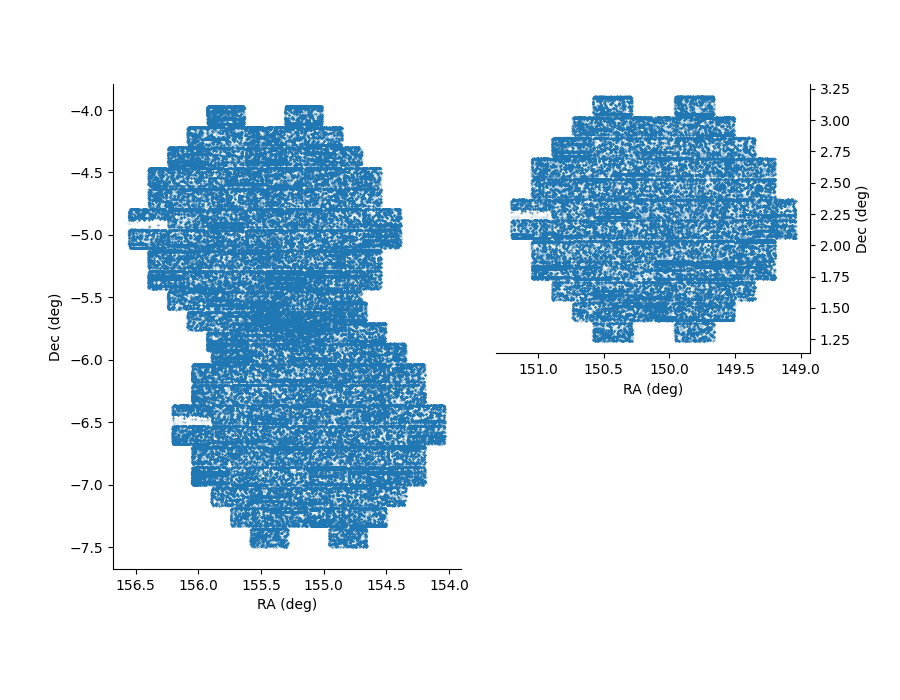

In [18]:
plt.figure(figsize=(9,7))

# Load all DiaSource coordinates from the diaSrcTable
raList = []
decList = []
for visit in visits:
    for detector in detectors:
        ra = butler.get('fakes_goodSeeingDiff_diaSrcTable', visit=visit, detector=detector).ra
        dec = butler.get('fakes_goodSeeingDiff_diaSrcTable', visit=visit, detector=detector).decl
        raList.append(ra)
        decList.append(dec)
ras = pd.concat(raList)
decs = pd.concat(decList)
df = pd.DataFrame({'ra': ras, 'dec': decs})

# Make the plot
ax1Filter = (df['dec'] > -2)
ax2Filter = (~ax1Filter)

ax1 = plt.subplot2grid((100, 100), (0, 55), rowspan=50, colspan=45)  # right, 1 HiTS field
ax2 = plt.subplot2grid((100, 100), (0, 0), rowspan=90, colspan=50)  # left, 2 HiTS fields

ax1.scatter(df.loc[ax1Filter, 'ra'], df.loc[ax1Filter, 'dec'],
            c='C0', s=0.1, alpha=0.2)
ax2.scatter(df.loc[ax2Filter, 'ra'], df.loc[ax2Filter, 'dec'],
            c='C0', s=0.1, alpha=0.2)

ax1.set_xlabel('RA (deg)')
ax2.set_xlabel('RA (deg)')
ax1.set_ylabel('Dec (deg)')
ax2.set_ylabel('Dec (deg)')
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax1.invert_xaxis()
ax2.invert_xaxis()
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')
plt.subplots_adjust(wspace=0.1, hspace=0)

## Now that we have the plot we want, let's analysis_tools-ify it

In [286]:
class PanelConfig(Config):
    """Configuration options for plot panels.
    """
    topSpinesVisible = Field[bool](
        doc="Draw line and ticks on top of panel?",
        default=False,
    )
    bottomSpinesVisible = Field[bool](
        doc="Draw line and ticks on bottom of panel?",
        default=True,
    )
    leftSpinesVisible = Field[bool](
        doc="Draw line and ticks on left side of panel?",
        default=True,
    )
    rightSpinesVisible = Field[bool](
        doc="Draw line and ticks on right side of panel?",
        default=True,
    )
    subplot2gridShapeRow = Field[int](
        doc="Number of rows of the grid in which to place axis. If None, panel is placed in a simple grid.",
        default=None,
    )
    subplot2gridShapeColumn = Field[int](
        doc="Number of columns of the grid in which to place axis. If None, panel is placed in a simple grid.",
        default=None,
    )
    subplot2gridLocRow = Field[int](
        doc="Row of the axis location within the grid. If None, panel is placed in a simple grid.",
        default=None,
    )
    subplot2gridLocColumn = Field[int](
        doc="Column of the axis location within the grid. If None, panel is placed in a simple grid.",
        default=None,
    )
    subplot2gridRowspan = Field[int](
        doc="Number of rows for the axis to span downwards. Only used if the the shape and loc are not None.",
        default=5,
    )
    subplot2gridColspan = Field[int](
        doc="Number of rows for the axis to span to the right. Only used if the shape and loc are not None.",
        default=5,
    )

class DiaSkyPanel(PanelConfig):
    """Configuration options DiaSkyPlot panels.
    """
    xlabel = Field[str](
        doc="Panel x-axis label.",
        default="RA (deg)",
    )
    ylabel = Field[str](
        doc="Panel y-axis label.",
        default="Dec (deg)",
    )
    invertXAxis = Field[bool](
        doc="Invert x-axis?",
        default=True,
    )
    color = Field[str](
        doc="Point color",
        default='C0',
    )
    size = Field[float](
        doc="Point size",
        default=2,
    )
    alpha = Field[float](
        doc="Point transparency",
        default=0.5,
    )
    # Eventually we might retrieve data from more columns to make the plot prettier/more information rich
    ra = Field[str](
        doc="Name of RA column",
        optional=False,
    )
    dec = Field[str](
        doc="Name of Dec column",
        optional=False,
    )
    
class DiaSkyPlot(PlotAction):
    """Generic pseudo base class for plotting DiaSources (or DiaObjects) on the sky.
    """
    panels = ConfigDictField(
        doc="A configurable dict describing the panels to be plotted (both data columns and layouts).",
        keytype=str,
        itemtype=DiaSkyPanel,
        default={},
    )
    
    def getInputSchema(self) -> KeyedDataSchema:
        """Defines the schema this plot action expects (the keys it looks for and what type they should be).
        In other words, verifies that the input data has the columns we are expecting with the right dtypes.
        """
        for panel in self.panels.values():
            yield (panel.ra, Vector)
            yield (panel.dec, Vector)

    def __call__(self, data: KeyedData, **kwargs) -> Mapping[str, Figure] | Figure:
        return self.makePlot(data, **kwargs)

    def makePlot(self, data: KeyedData, **kwargs) -> Figure:
        """Make an N-panel plot with locations of DiaSources or DiaObjects displayed in each panel.
        
        Parameters
        ----------
        data : `lsst.analysis.tools.interfaces.KeyedData`
        
        Returns
        -------
        fig : `matplotlib.figure.Figure`
        """
        if 'figsize' in kwargs:
            figsize = kwargs.pop('figsize', '')
            fig = plt.figure(figsize=figsize)
        else:
            fig = plt.figure()
        axs = self._makeAxes(fig)
        for panel, ax in zip(self.panels.values(), axs):
            self._makePanel(data, panel, ax, **kwargs)
        plt.draw()
        return fig

    def _makeAxes(self, fig):
        """Determine axes layout for main figure.
        
        If no subplot2grid shape or location info is configured, the plot will be a simple grid.
        Each panel that does have subplot2grid configs will use matplotlib's subplot2grid to
        determine the panel geometry, which calls gridspec under the hood.

        Parameters
        ----------
        fig : `matplotlib.figure.Figure`
        
        Returns
        -------
        axs : `list` containing one or more matplotlib axes, one for each panel
        """        
        axs = []
        for count, panel in enumerate(self.panels.values()):
            subplot2gridShape = (panel.subplot2gridShapeRow, panel.subplot2gridShapeColumn)
            subplot2gridLoc = (panel.subplot2gridLocRow, panel.subplot2gridLocColumn)
            if (None in subplot2gridShape) | (None in subplot2gridLoc):
                # Make a simple grid layout
                nPanels = len(self.panels)
                if np.floor(np.sqrt(nPanels)) - np.sqrt(nPanels) == 0:
                    squareGridSize = int(np.sqrt(nPanels))
                else:
                    squareGridSize = int(np.sqrt(nPanels)) + 1
                axs.append(fig.add_subplot(squareGridSize, squareGridSize, count + 1, aspect='equal'))
            else:
                # Use subplot2grid with panel configs
                axs.append(plt.subplot2grid(subplot2gridShape,
                                            subplot2gridLoc,
                                            rowspan=panel.subplot2gridRowspan,
                                            colspan=panel.subplot2gridColspan))
        return axs
    
    def _makePanel(self, data, panel, ax, **kwargs):
        """Plot a single panel.
        
        Parameters
        ----------
        data : `lsst.analysis.tools.interfaces.KeyedData`
        panel : `DiaSkyPanel`
        ax : matplotlib axis
        color : `str`
        """       
        ras = cast(Vector, data[panel.ra])
        decs = cast(Vector, data[panel.dec])

        ax.scatter(ras, decs, c=panel.color, s=panel.size, alpha=panel.alpha)
        # ax.legend()  # later
        ax.set_xlabel(panel.xlabel)
        ax.set_ylabel(panel.ylabel)
        
        if panel.invertXAxis:
            ax.invert_xaxis()
        if panel.topSpinesVisible:
            ax.spines['top'].set_visible(True)
        else:
            ax.spines['top'].set_visible(False)
        if not panel.bottomSpinesVisible:  # default is True
            ax.spines['bottom'].set_visible(False)
        if not panel.leftSpinesVisible:
            # Default is True; if False, we also want ticks and labels on the right
            ax.spines['left'].set_visible(False)
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position('right')
        if not panel.rightSpinesVisible:  # default is True
            ax.spines['right'].set_visible(False)

In [287]:
#from lsst.analysis.tools.actions.plot.diaSkyPlot import DiaSkyPlot, DiaSkyPanel  # these don't exist yet

class HitsDiaPlot(AnalysisPlot):
    """Specialized plotter that calls the more generic DiaSkyPlot for plotting RA/Dec of DiaSources.
    
    It makes two panels that make the HiTS fields look pretty. It requires both process and produce steps.
    """
    def setDefaults(self):
        super().setDefaults()
      
        # This version plots all the RA and Dec points
        #self.process.buildActions.ra1s = LoadVector()
        #self.process.buildActions.ra1s.vectorKey = 'ra'
        #self.process.buildActions.dec1s = LoadVector()
        #self.process.buildActions.dec1s.vectorKey = 'dec'
        
        self.process.buildActions.ra1s = DownselectVector(vectorKey='ra',
                                                          selector=RangeSelector(column='dec', maximum=-2))
        self.process.buildActions.dec1s = DownselectVector(vectorKey='dec',
                                                           selector=RangeSelector(column='dec', maximum=-2))
        self.process.buildActions.ra2s = DownselectVector(vectorKey='ra',
                                                          selector=RangeSelector(column='dec', minimum=-2))
        self.process.buildActions.dec2s = DownselectVector(vectorKey='dec',
                                                           selector=RangeSelector(column='dec', minimum=-2))

        self.produce = DiaSkyPlot()
        
        # Right panel: single HiTS field
        self.produce.panels['panel_right'] = DiaSkyPanel()
        self.produce.panels['panel_right'].xlabel = 'RA (deg)'
        self.produce.panels['panel_right'].ylabel = 'Dec (deg)'
        self.produce.panels['panel_right'].ra = 'ra1s'
        self.produce.panels['panel_right'].dec = 'dec1s'
        self.produce.panels['panel_right'].rightSpinesVisible = False
        self.produce.panels['panel_right'].size = 0.1
        self.produce.panels['panel_right'].alpha = 0.2
        subplot2gridShape = (100, 100)
        subplot2gridLoc = (0, 0)
        self.produce.panels['panel_right'].subplot2gridShapeRow = subplot2gridShape[0]
        self.produce.panels['panel_right'].subplot2gridShapeColumn = subplot2gridShape[1]
        self.produce.panels['panel_right'].subplot2gridLocRow = subplot2gridLoc[0]
        self.produce.panels['panel_right'].subplot2gridLocColumn = subplot2gridLoc[1]
        self.produce.panels['panel_right'].subplot2gridRowspan = 90
        self.produce.panels['panel_right'].subplot2gridColspan = 50
        
        # Left panel: two overlapping HiTS fields
        self.produce.panels['panel_left'] = DiaSkyPanel()
        self.produce.panels['panel_left'].xlabel = 'RA (deg)'
        self.produce.panels['panel_left'].ylabel = 'Dec (deg)'
        self.produce.panels['panel_left'].ra = 'ra2s'
        self.produce.panels['panel_left'].dec = 'dec2s'
        self.produce.panels['panel_left'].leftSpinesVisible = False
        self.produce.panels['panel_left'].size = 0.1
        self.produce.panels['panel_left'].alpha = 0.2
        subplot2gridShape = (100, 100)
        subplot2gridLoc = (0, 55)
        self.produce.panels['panel_left'].subplot2gridShapeRow = subplot2gridShape[0]
        self.produce.panels['panel_left'].subplot2gridShapeColumn = subplot2gridShape[1]
        self.produce.panels['panel_left'].subplot2gridLocRow = subplot2gridLoc[0]
        self.produce.panels['panel_left'].subplot2gridLocColumn = subplot2gridLoc[1]
        self.produce.panels['panel_left'].subplot2gridRowspan = 50
        self.produce.panels['panel_left'].subplot2gridColspan = 45

In [288]:
# If you're running the notebook from top to bottom, `df` is already defined

###
# This bit should land in a runQuantum method for a new pipelineTask to create a metric, which we can then plot
# That way, this code is available for making all kinds of various plots
# Note that analysis_tools has Tasks, Eric wrote one

#raList = []
#decList = []
#for visit in visits:
#    for detector in detectors:
#        ra = butler.get('fakes_goodSeeingDiff_diaSrcTable', visit=visit, detector=detector).ra
#        dec = butler.get('fakes_goodSeeingDiff_diaSrcTable', visit=visit, detector=detector).decl
#        raList.append(ra)
#        decList.append(dec)
#ras = pd.concat(raList)
#decs = pd.concat(decList)
#df = pd.DataFrame({'ra': ras, 'dec': decs})
###


<IPython.core.display.Javascript object>


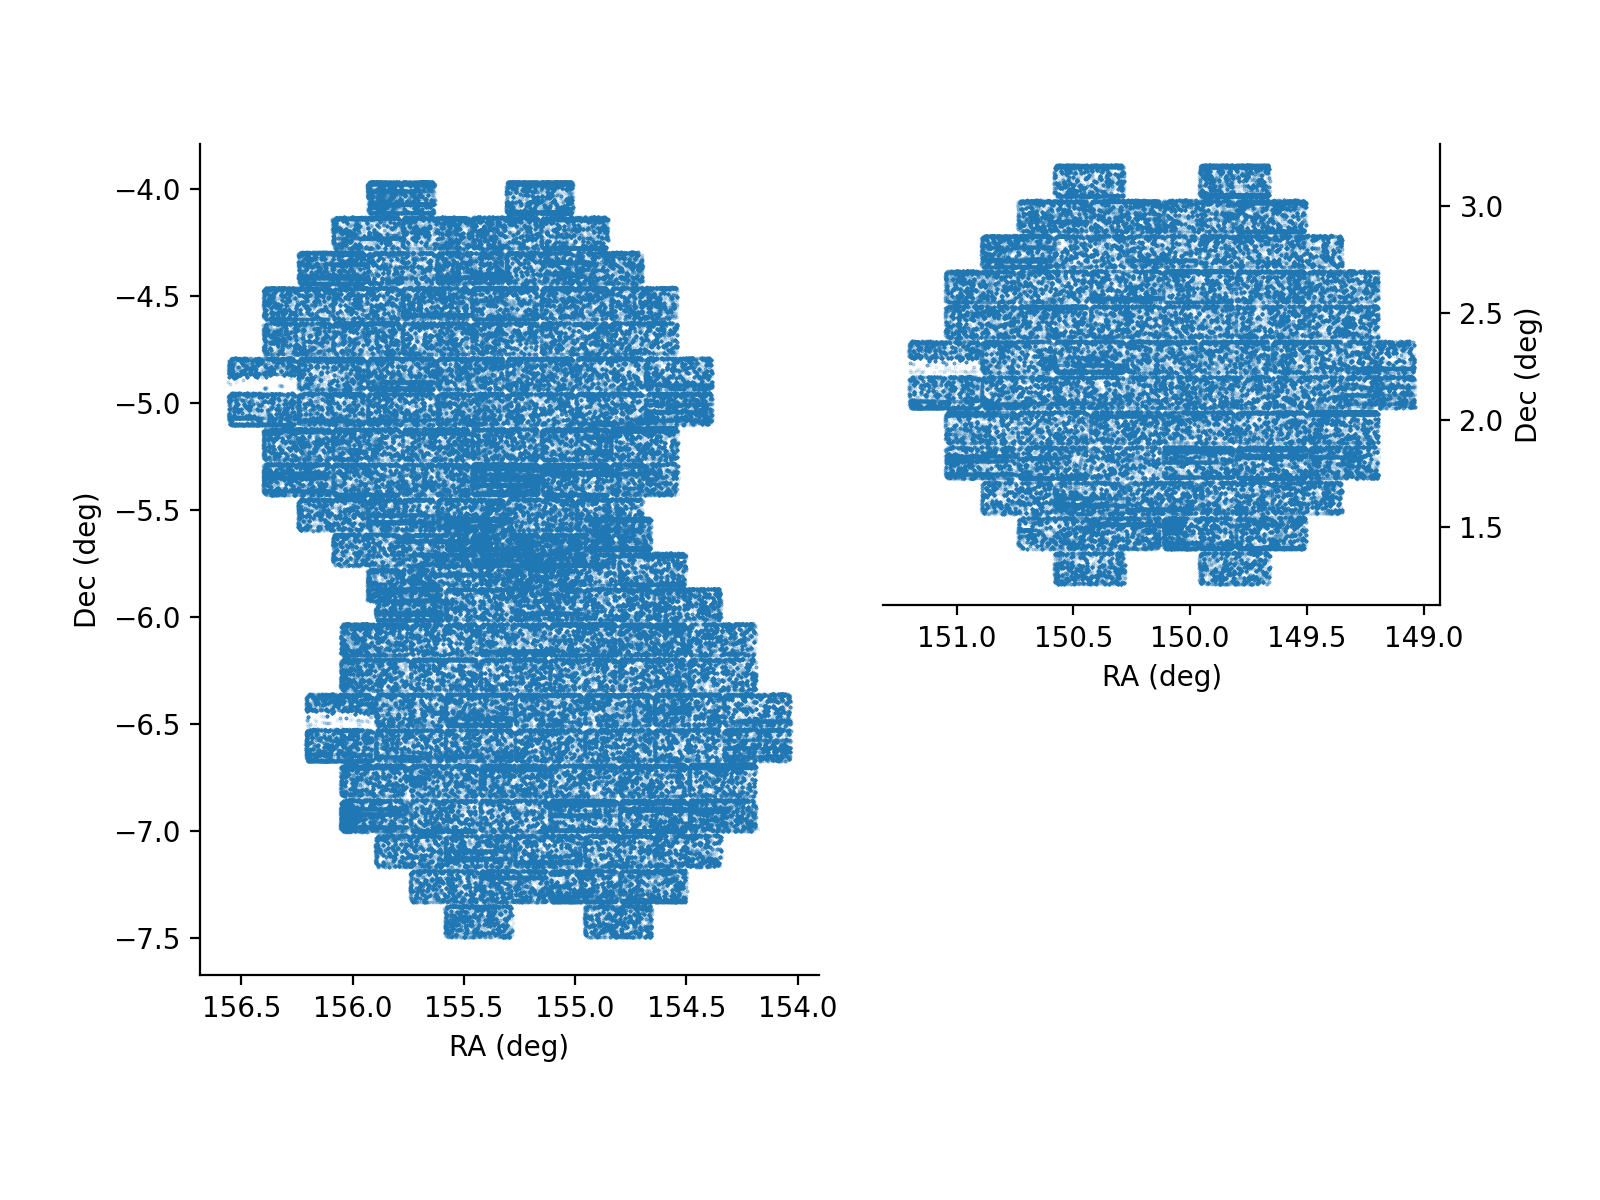

In [289]:
# Call the things we wrote to actually make the plot

plot = HitsDiaPlot()(df, figsize=(8,6))

# Fancy way to do this one step at a time
#plot.populatePrepFromProcess()
#stage1 = plot.prep(df)
#stage1.addInputSchema()
#print(stage1)  # should contain all columns needed for the plot
#stage2 = plot.process(stage1)
#print(stage2)
#stage3 = plot.produce(stage2)
#print(stage3)